In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
print('TensorFlow {}; Keras {}'.format(tf.__version__, keras.__version__))

TensorFlow 2.5.0; Keras 2.5.0


In [3]:
import numpy as np

In [4]:
np.__version__

'1.19.5'

In [6]:
import random

In [7]:
from scipy import ndimage

In [8]:
!nvidia-smi

Tue Feb  8 01:25:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   33C    P0    32W / 300W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   

In [9]:
import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [11]:

def dice_coef_4cat(y_true, y_pred, smooth=1e-7):
    '''
    Dice coefficient for 4 categories. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=4)[...,1:])
#     y_true_f = K.flatten(y_true[...,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return 1- K.mean((2. * intersect / (denom + smooth)))

In [2]:

import glob
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import mse
from tensorflow.keras.regularizers import l2, l1
import gc
from tensorflow import keras
import matplotlib.pyplot as plt
from keras_unet_collection import models
from tensorflow.keras.models import Model
import numpy as np


from pathlib import Path

from tqdm import tqdm
import cv2

from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    Normalize,
    Compose,
    PadIfNeeded,
    RandomCrop,
    CenterCrop
)


ModuleNotFoundError: No module named 'keras_unet_collection'

In [13]:
from keras_unet_collection import models

In [14]:
model_unet = models.unet_2d((1024, 1280,3), [64, 128, 256, 512], n_labels=4,
                      stack_num_down=2, stack_num_up=1,
                      activation='GELU', output_activation='Softmax', 
                      batch_norm=True, pool='max', unpool='nearest', name='unet')

2022-02-08 01:26:57.797979: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-02-08 01:26:57.907146: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:0b:00.0 name: Tesla P100-SXM2-16GB computeCapability: 6.0
coreClock: 1.4805GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-02-08 01:26:57.907252: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-02-08 01:26:57.914087: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-02-08 01:26:57.914166: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-02-08 01:26:57.916116: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuff

In [36]:
model_unet.load_weights("./small_unet_0_new/" + "model_unet3D_distillation_test_420.h5")

In [18]:

def load_image(path):
    img = cv2.imread(str(path))
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


def load_mask(path, problem_type):
    if problem_type == 'binary':
        mask_folder = 'binary_masks'
        factor = binary_factor
    elif problem_type == 'parts':
        mask_folder = 'parts_masks'
        factor = parts_factor
    elif problem_type == 'instruments':
        factor = instrument_factor
        mask_folder = 'instruments_masks'

    mask = cv2.imread(str(path).replace('images', mask_folder).replace('jpg', 'png'), 0)

    return (mask / factor).astype(np.uint8)

def get_split(fold):
    folds = {0: [1],
             1: [2, 5],
             2: [4, 8],
             3: [6, 7]}

    train_path = data_path / 'cropped_train'

    train_file_names = []
    val_file_names = []
    test_file_names = []

    for instrument_id in range(1, 9):
        if instrument_id in folds[fold]:
            val_file_names += list((train_path / ('instrument_dataset_' + str(instrument_id)) / 'images').glob('*'))
        elif instrument_id==3:
            test_file_names += list((train_path / ('instrument_dataset_' + str(instrument_id)) / 'images').glob('*'))
        else:
            train_file_names += list((train_path / ('instrument_dataset_' + str(instrument_id)) / 'images').glob('*'))

    return train_file_names, val_file_names,test_file_names

# def get_split(fold):
#     folds = {0: [1, 3],
#              1: [2, 5],
#              2: [4, 8],
#              3: [6, 7]}

#     train_path = data_path / 'cropped_train'

#     train_file_names = []
#     val_file_names = []

#     for instrument_id in range(1, 9):
#         if instrument_id in folds[fold]:
#             val_file_names += list((train_path / ('instrument_dataset_' + str(instrument_id)) / 'images').glob('*'))
#         else:
#             train_file_names += list((train_path / ('instrument_dataset_' + str(instrument_id)) / 'images').glob('*'))

#     return train_file_names, val_file_names


def train_transform(p=1):
        return Compose([
            PadIfNeeded(min_height=1024, min_width=1280, p=1),
            RandomCrop(height=1024, width=1280, p=1),
            VerticalFlip(p=0.5),
            HorizontalFlip(p=0.5),
            Normalize(p=1)
        ], p=p)

def val_transform(p=1):
    return Compose([
        PadIfNeeded(min_height=1024, min_width=1280, p=1),
        CenterCrop(height=1024, width=1280, p=1),
        Normalize(p=1)
    ], p=p)

def aug_fu_val(image,label):
    v_transform = val_transform()
    data = {"image":image,"label":label}
    aug_data = v_transform(**data)
    aug_img = aug_data["image"]
    aug_label = aug_data["label"]
    return aug_img,aug_label


def aug_fu_train(image,label):
    transform = train_transform()
    data = {"image":image,"label":label}
    aug_data = transform(**data)
    aug_img = aug_data["image"]
    aug_label = aug_data["label"]
    return aug_img,aug_label

def preprocess_train_data(images_T,labels_T):
    aug_imgs_T = np.zeros(images_T.shape)
    aug_labels_T = np.zeros(labels_T.shape)
    for i in range(len(images_T)):
        aug_imgs_T[i], aug_labels_T[i]=aug_fu_train(images_T[i],labels_T[i])
    return aug_imgs_T,aug_labels_T


def preprocess_val_data(images_V,labels_V):
    aug_imgs_V = np.zeros(images_V.shape)
    aug_labels_V = np.zeros(labels_V.shape)
    for i in range(len(images_V)):
        aug_imgs_V[i], aug_labels_V[i]=aug_fu_val(images_V[i],labels_V[i])
    return aug_imgs_V,aug_labels_V



In [19]:
data_path = Path('/raid/pengcheng.xu/miccai_endo/')

train_path = data_path / 'train'

cropped_train_path = data_path / 'cropped_train'

original_height, original_width = 1080, 1920
height, width = 1024, 1280
h_start, w_start = 28, 320

binary_factor = 255
parts_factor = 85
instrument_factor = 32

train_file_names, val_file_names,test_file_names = get_split(0)

In [17]:
temp_mask = load_mask(train_file_names[0],'parts')

In [18]:
temp_mask.shape

(1024, 1280)

In [19]:
np.unique(temp_mask)

array([0, 1, 2, 3], dtype=uint8)

In [20]:



train_images = []
train_masks = []

for i in range(len(train_file_names)):
    temp_img = load_image(train_file_names[i])
    temp_mask = load_mask(train_file_names[i],'parts')
    train_images.append(temp_img)
    train_masks.append(temp_mask) 


val_images = []
val_masks = []

for i in range(len(val_file_names)):
    temp_img = load_image(val_file_names[i])
    temp_mask = load_mask(val_file_names[i],'parts')
    val_images.append(temp_img)
    val_masks.append(temp_mask)
    
test_images = []
test_masks = []

for i in range(len(test_file_names)):
    temp_img = load_image(test_file_names[i])
    temp_mask = load_mask(test_file_names[i],'parts')
    test_images.append(temp_img)
    test_masks.append(temp_mask)

train_images_arr = np.array(train_images)
train_masks_arr = np.array(train_masks)

val_images_arr = np.array(val_images)
val_masks_arr = np.array(val_masks)

test_images_arr = np.array(test_images)
test_masks_arr = np.array(test_masks)

In [22]:
test_masks_arr.shape,val_masks_arr.shape,train_masks_arr.shape

((225, 1024, 1280), (225, 1024, 1280), (1350, 1024, 1280))

In [21]:
aug_img_val, aug_label_val = preprocess_val_data(val_images_arr,val_masks_arr)

In [22]:
aug_img_test, aug_label_test = preprocess_val_data(test_images_arr,test_masks_arr)

In [25]:
np.unique(aug_label_val)

array([0., 1., 2., 3.])

In [23]:
import time

In [30]:
t_start = time.time()
u_net_pre = model_unet.predict(aug_img_val,batch_size=1)
t_end = time.time()
inf_time = (t_end - t_start)/225
print(inf_time)

0.2695286210378011


In [26]:
def IOU_CCE_loss(y_true, y_pred):


    y_true = K.one_hot(K.cast(y_true, 'int32'), num_classes=4)
#     _cce_loss_fu = tf.keras.losses.CategoricalCrossentropy()
    cce_loss = tf.keras.losses.CategoricalCrossentropy(y_true,y_pred)
    loss = 0.7 * cce_loss
    
    for cls_index in range(4):
        y_pred_single = K.flatten(y_pred[...,cls_index])
        y_true_single = K.flatten(y_true[...,cls_index])

        class_intersection = K.sum(y_true_single * y_pred_single)
        class_loss = (class_intersection + 1) / (K.sum(y_true_single) + K.sum(y_pred_single) - class_intersection + 1)
        _iou_loss = 0.3*tf.math.log(class_loss)
        loss = loss- _iou_loss
   
    print(cce_loss,loss)
    return loss

In [23]:
inf_time

0.07990186161465115

In [35]:
u_net_pre = model_unet.predict(aug_img_val,batch_size=1)

In [36]:
u_net_pre_test = model_unet.predict(aug_img_test,batch_size=1)

In [37]:
IOU(aug_label_test.astype(np.float32),u_net_pre_test)

0 tf.Tensor(0.87465715, shape=(), dtype=float32)
1 tf.Tensor(0.41211024, shape=(), dtype=float32)
2 tf.Tensor(0.26594764, shape=(), dtype=float32)
3 tf.Tensor(0.16777611, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=0.16777611>

In [38]:
IOU(aug_label_val.astype(np.float32),u_net_pre)

0 tf.Tensor(0.8656458, shape=(), dtype=float32)
1 tf.Tensor(0.3319569, shape=(), dtype=float32)
2 tf.Tensor(0.19963844, shape=(), dtype=float32)
3 tf.Tensor(0.21441913, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=0.21441913>

In [25]:
def IOU(y_true, y_pred):
    y_true = K.one_hot(K.cast(y_true, 'int32'), num_classes=4)
    for cls_index in range(4):
        y_pred_single = K.flatten(y_pred[...,cls_index])
        y_true_single = K.flatten(y_true[...,cls_index])

        class_intersection = K.sum(y_true_single * y_pred_single)
        class_loss = (class_intersection + 1) / (K.sum(y_true_single) + K.sum(y_pred_single) - class_intersection + 1)
#         _iou_loss = 0.3*tf.math.log(class_loss)
        print(cls_index,class_loss)
#         loss = loss- _iou_loss
    
    return class_loss

In [26]:
def IOU_CE_loss(y_true, y_pred):
    y_pred = K.batch_flatten(y_pred)
    y_true = K.batch_flatten(y_true)

    _bce_loss_fu = loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
    ce_loss = _bce_loss_fu(y_true, y_pred)
    
    
    class_intersection = K.sum(y_true * y_pred)
    class_loss = (class_intersection + 1) / (K.sum(y_true) + K.sum(y_pred) - class_intersection + 1)
    print(ce_loss.numpy(),class_loss.numpy())
   
    
    return 0.7*ce_loss - 0.3*tf.math.log(class_loss)

In [18]:
def _my_gray2hot(_gray_label):
    _gray_label = _gray_label.astype(np.int8)
    n_values = 4
    label_hot = np.eye(n_values)[_gray_label]
#     label_hot = np.squeeze(label_hot,axis=-2)
    return label_hot

def _my_hot2gray(_hot_label):
    label_gray = np.argmax(_hot_label, axis=-1)
    return label_gray
# def one_hot(a, num_classes):
#     return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

In [22]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


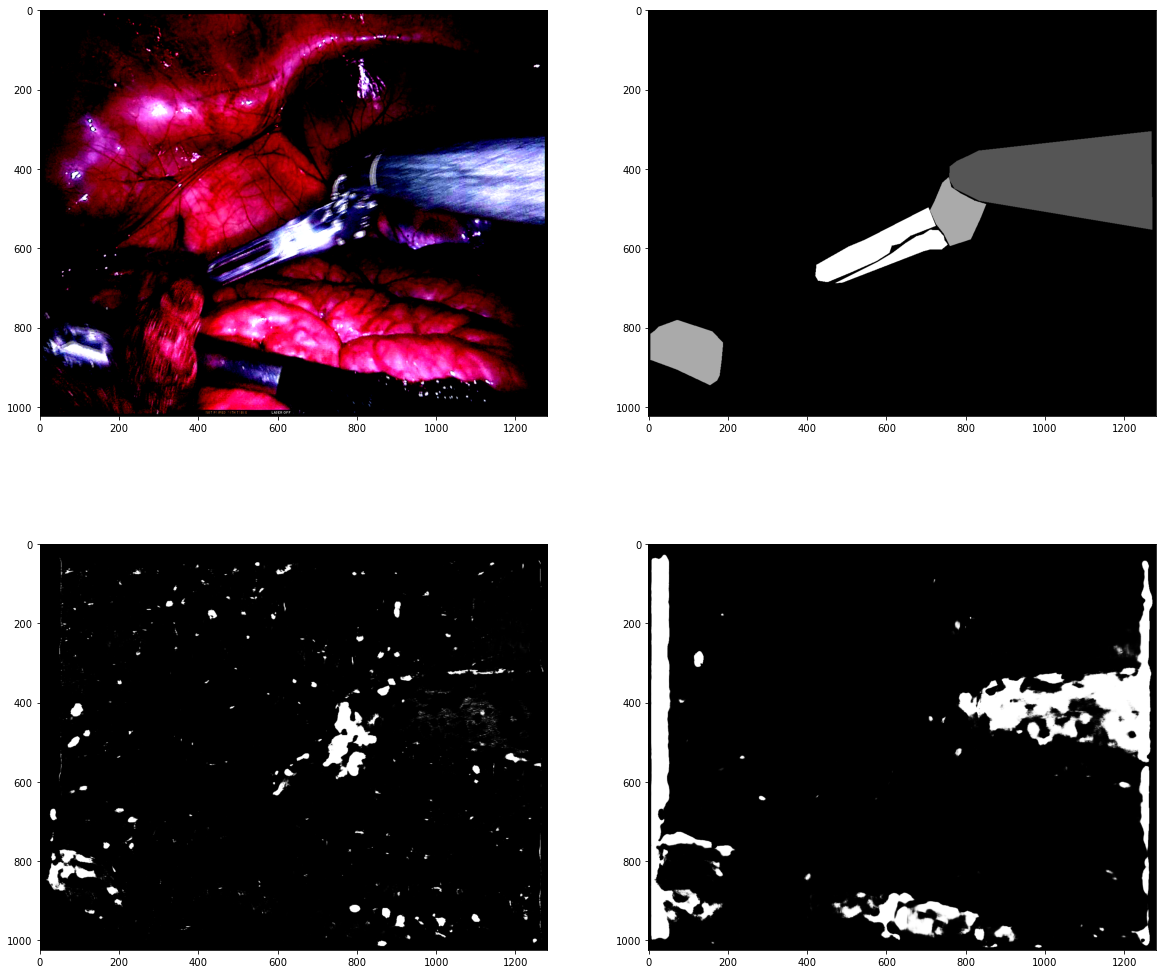

In [50]:
plt.figure(figsize=(20, 18))
plt.subplot(2,2,1)
plt.imshow(aug_img_val[125,:,:],cmap='gray')
plt.subplot(2,2,2)
plt.imshow(aug_label_val[125,:,:],cmap='gray')
plt.subplot(2,2,3)
plt.imshow(u_net_pre[125,:,:,2],cmap='gray')
plt.subplot(2,2,4)
plt.imshow(u_net_pre[125,:,:,1],cmap='gray')

In [123]:
train_labels_load = _my_gray2hot(train_labels_load)

In [124]:
labels_load = _my_gray2hot(labels)